Haim Zisman  
Ori Malca

# Pre-requirements & Definitions

load dataset and dependencies file

In [1]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 17B6to-SYO_KbdsUmIaIde6j3ghfa6Grx

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17B6to-SYO_KbdsUmIaIde6j3ghfa6Grx
To: /content/insurance.csv
100% 55.6k/55.6k [00:00<00:00, 53.0MB/s]


Environment Setup Installation (can be escaped)

## Imports

In [2]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")  # Set seaborn style for plots
import matplotlib.pyplot as plt
import functools

from scipy import stats
from scipy.stats import uniform, randint, norm, zscore, mannwhitneyu, ttest_ind, f_oneway,  probplot, kstest
import shap

from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Constants

In [4]:
NUMERICAL_FEATURES = ['age', 'bmi', 'children', 'charges']
CATEGORICAL_FEATURES = ['sex', 'smoker', 'region']
FEATURES = CATEGORICAL_FEATURES + NUMERICAL_FEATURES

# Constants
LABEL = 'charges'
SEED = 0

# Visualization Hyperparameters
TITLE_FONT_SIZE = 12
PLOT_TEXT_SIZE = 11

# Label Occurrences
FIGURE_SIZE = (6, 4)

# Correlation Matrix
CORR_FIGURE_SIZE = (12, 6)
VALUE_FORMATING = ".2f"
CORR_PALETTE = "ch:s=-.2,r=.6"

# Training
TEST_PORTION = 0.1
METRIC_FP_PRECISION = 3
METRIC_CRITERIA = 'mean_squared_error'
SCIKIT_METRIC_CRITERIA = 'neg_mean_squared_error'
NUM_KFOLD = 10

## Metrics Definition

In [5]:
metrics_dict = {
    'rmse': lambda labels, preds: functools.partial(mean_squared_error, squared=False)(labels, preds),
    'mean_squared_error': lambda labels, preds: mean_squared_error(labels, preds),
    'mean_absolute_error': lambda labels, preds: mean_absolute_error(labels, preds),
    'r2_score': lambda labels, preds: r2_score(labels, preds),
}

## Loading dataset

In [6]:
file_path = '/content/insurance.csv'
df = pd.read_csv(file_path)
df.insert(0, 'index', df.index)

# Dataset Analysis

The Medical Cost Personal Dataset includes features like `age`, `sex`, `BMI`, `number of children`, `smoking status`, and `region`. The `charges` feature represents individual medical costs billed by insurance. These variables help identify how personal factors like health, lifestyle, and regional differences impact medical expenses.


## Data Structure

Data Quality and Nullness

In [7]:
missing_values = df[FEATURES].isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
sex         0
smoker      0
region      0
age         0
bmi         0
children    0
charges     0
dtype: int64


Based on the null counts provided for the dataset, it can be concluded that there are no missing values across all features listed.

duplicated rows check and remove if there are any

In [8]:
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
df = df.drop_duplicates()

Number of duplicate rows: 0


total observations after removing duplicates

In [9]:
f"Number of Samples: {df.shape[0]}"

'Number of Samples: 1338'

checking possible values and data type of the features

In [10]:
data = []
for column in FEATURES:
    if df[column].dtype == 'object':
        unique_vals = df[column].unique()
        possible_values = "{" + ', '.join(map(str, unique_vals)) + "}"
    else:
        min_val = df[column].min()
        max_val = df[column].max()
        possible_values = f"[{min_val}, {max_val}]"
    data.append([column, possible_values, df[column].dtype])

summary_df = pd.DataFrame(data, columns=['Column Name', 'Possible Values', 'Data Type'], index=FEATURES)
summary_df

,Column Name,Possible Values,Data Type
sex,sex,"{female, male}",object
smoker,smoker,"{yes, no}",object
region,region,"{southwest, southeast, northwest, northeast}",object
age,age,"[18, 64]",int64
bmi,bmi,"[15.96, 53.13]",float64
children,children,"[0, 5]",int64
charges,charges,"[1121.8739, 63770.42801]",float64


Our data consists of numeric and categorical measurements

## Quantitative Measure of Skewness for numerical features

In [11]:
skewness_rate_df = df[NUMERICAL_FEATURES].skew().sort_values(ascending=False)
skewness_rate_df

,0
charges,1.515880
children,0.938380
bmi,0.284047
age,0.055673


All features are right-skewed in different scales. Further Outliers & Skewness investigation is needed.

## Features Distribution Visualization

### Categorical Features

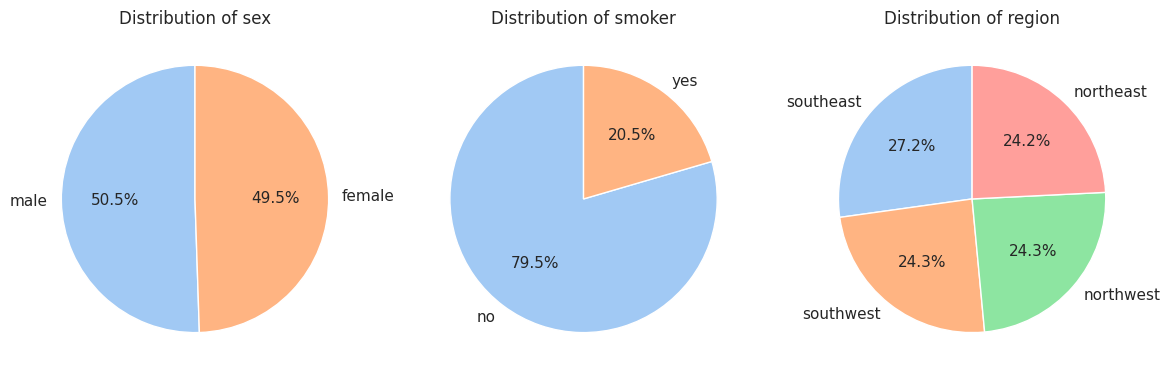

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjusted to fit only 1 row

for i, var in enumerate(CATEGORICAL_FEATURES):
    df[var].value_counts().plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel"),
        ax=axs[i],
        textprops={'fontsize': PLOT_TEXT_SIZE}
    )
    axs[i].set_title(f'Distribution of {var}', fontsize=TITLE_FONT_SIZE)
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

### Numeric Features

In [13]:
df.columns

Index(['index', 'age', 'sex', 'bmi', 'children', 'smoker', 'region',
       'charges'],
      dtype='object')

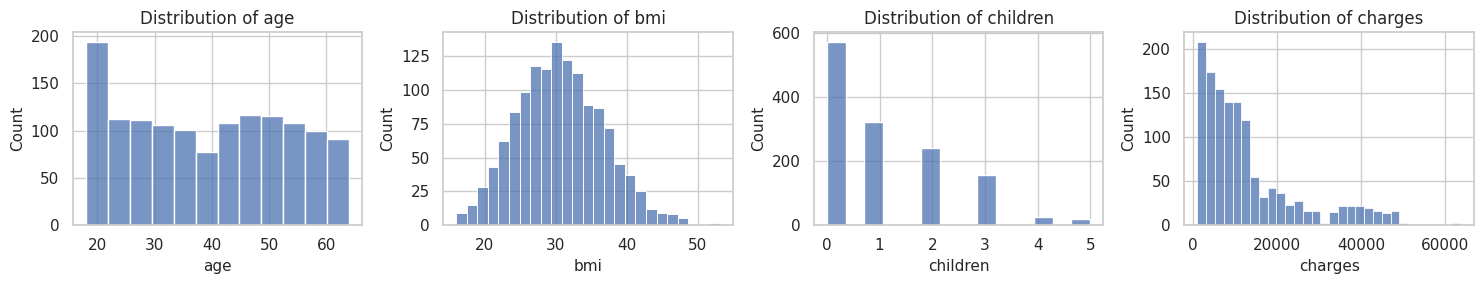

In [14]:
fig, axs = plt.subplots(1, len(NUMERICAL_FEATURES), figsize=(15, 3))  # Adjusted to fit only 1 row

for i, var in enumerate(NUMERICAL_FEATURES):
    sns.histplot(df[var], kde=False, ax=axs[i])
    axs[i].set_title(f'Distribution of {var}', fontsize=TITLE_FONT_SIZE)
    axs[i].set_xlabel(var, fontsize=PLOT_TEXT_SIZE)
    axs[i].set_ylabel('Count', fontsize=PLOT_TEXT_SIZE)

plt.tight_layout()
plt.show()

#### Empirical Observations:


---


1. Seems like `bmi` is normally distributed.
2. `age` is almost uniformly distributed.
3. `charges` is NOT normally distributed. Seems more like an exponential distribution (Log-transformation is applied later to get more of a guassian-like shape and reduce overall skewness).
4. `regions` are fairly balanced.
5. An imbalance between the two classes of `smoker`, with "no" cases being more common than "yes".


---


## Numerical Data Distribution Description

In [15]:
df[FEATURES].describe().drop('count', axis=0).T

,mean,std,min,25%,50%,75%,max
age,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


#### Observations


---


1. Data range variability, like in `charges` and `bmi`, suggests potential outliers and the need for normalization.

2. Outliers: Significant difference between the Q3 and max value (or min value and Q1) suggest outliers' existence.  
Examples:
  - `charges` Q3=16657.71, max=63770.42
  - `bmi` Q3=34.7, max=53.13 (where std=6.09)

Log-transform `charge` to make it more guassian-like and reduce skewness

In [16]:
df[LABEL] = df[LABEL].apply(np.log)

Let's see how `charges` distribution looks after the transformation

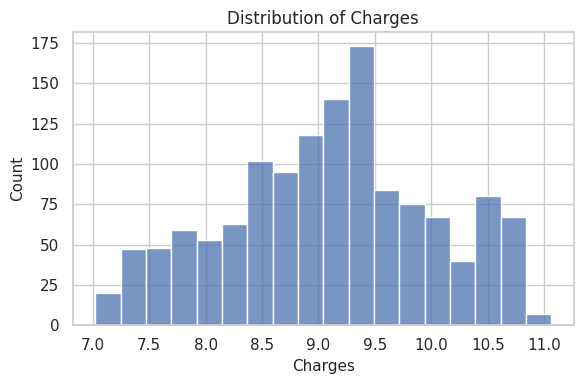

In [17]:
fig, axs = plt.subplots(1, 1, figsize=FIGURE_SIZE)
sns.histplot(df[LABEL], kde=False, ax=axs)
axs.set_title('Distribution of Charges', fontsize=TITLE_FONT_SIZE)
axs.set_xlabel('Charges', fontsize=PLOT_TEXT_SIZE)
axs.set_ylabel('Count', fontsize=PLOT_TEXT_SIZE)
plt.tight_layout()
plt.show()

After applying the transformation the `charges` distribution resembles more of a guassian shape, and overall skewness is significantly reduced.

## Normality Check - Numeric Features

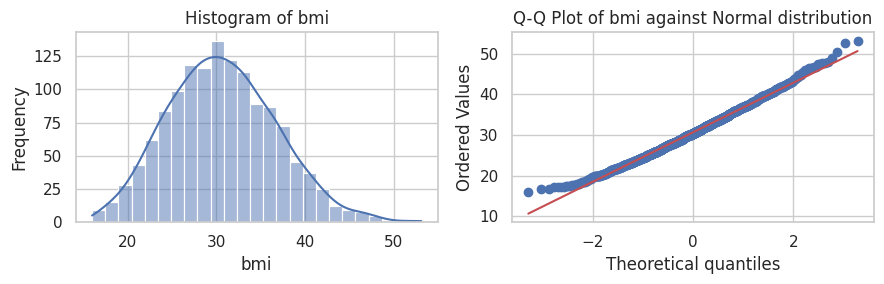

Kolmogorov-Smirnov Test for bmi against Normal distribution
Statistic: 0.026099881197044872, p-value: 0.3162798242838005
bmi follows Normal distribution (fail to reject H0)



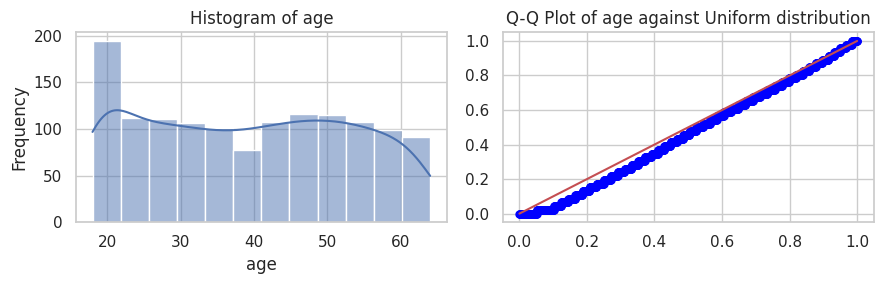

Kolmogorov-Smirnov Test for age against Uniform distribution
Statistic: 0.08065249886267628, p-value: 5.1074059011652943e-08
age does not follow Uniform distribution (reject H0)



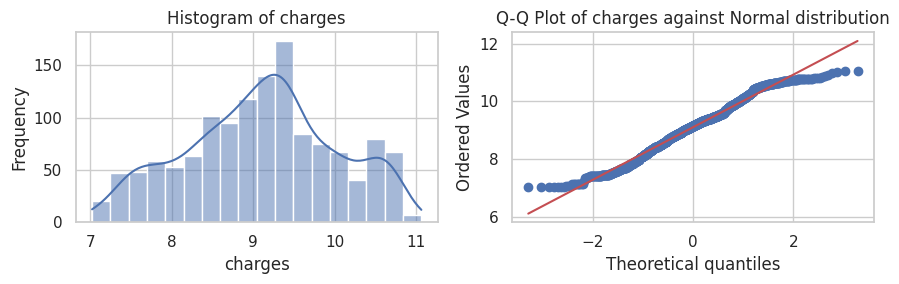

Kolmogorov-Smirnov Test for charges against Normal distribution
Statistic: 0.036508004036154396, p-value: 0.05511412337443955
charges follows Normal distribution (fail to reject H0)



In [18]:
def check_distribution(df, feature, distribution='norm'):
    data = df[feature]

    # Visual Inspection: Histogram and Q-Q Plot
    plt.figure(figsize=(9, 3))

    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    if distribution == 'norm':
        probplot(data, dist="norm", plot=plt)
        dist_name = "Normal"
    elif distribution == 'uniform':
        # Generate uniform Q-Q plot
        n = len(data)
        theoretical_quantiles = np.linspace(0, 1, n)
        sorted_data = np.sort((data - data.min()) / (data.max() - data.min()))  # Normalize to [0, 1]
        plt.plot(theoretical_quantiles, sorted_data, 'o', markersize=5, label='Data', color='blue')
        plt.plot(theoretical_quantiles, theoretical_quantiles, 'r-', label='Uniform Reference Line')
        dist_name = "Uniform"
    plt.title(f'Q-Q Plot of {feature} against {dist_name} distribution')

    plt.tight_layout()
    plt.show()

    # Statistical Test: Kolmogorov-Smirnov Test
    if distribution == 'norm':
        stat, p_value = kstest(data, 'norm', args=(data.mean(), data.std()))
    elif distribution == 'uniform':
        stat, p_value = kstest((data - data.min()) / (data.max() - data.min()), 'uniform', args=(0, 1))

    print(f'Kolmogorov-Smirnov Test for {feature} against {dist_name} distribution')
    print(f'Statistic: {stat}, p-value: {p_value}')
    if p_value > 0.05:
        print(f'{feature} follows {dist_name} distribution (fail to reject H0)')
    else:
        print(f'{feature} does not follow {dist_name} distribution (reject H0)')
    print()

# Example usage
# Check normality for 'bmi'
check_distribution(df, 'bmi', distribution='norm')

# Check uniformity for 'age'
check_distribution(df, 'age', distribution='uniform')

# Check normality for 'charges'
check_distribution(df, 'charges', distribution='norm')

# Regression Problem Definition

### Objective:

Predict **charges** using the following features:

$$
\mathbf{x}_i = (\text{age}, \text{sex}, \text{bmi}, \text{children}, \text{smoker}, \text{region})
$$

Minimize the error between predicted and actual charges:

$$
\hat{f} = \arg\min_{f} \text{MSE}(f) = \arg\min_{f} \frac{1}{n} \sum_{i=1}^{n} (y_i - f(\mathbf{x}_i))^2
$$

Where the criterion is the **MSE (Mean Squared Error)**.


# Data Visualizations

### Encode categorical features to numeric representation for Pearson Correlation

In [19]:
label_encoder = LabelEncoder()

for column in CATEGORICAL_FEATURES:
    df[column] = label_encoder.fit_transform(df[column])

### Pair-wise Pearson Correlation Heatmap

In [20]:
df[FEATURES]

,sex,smoker,region,age,bmi,children,charges
0,0,1,3,19,27.900,0,9.734176
1,1,0,2,18,33.770,1,7.453302
2,1,0,2,28,33.000,3,8.400538
3,1,0,1,33,22.705,0,9.998092
4,1,0,1,32,28.880,0,8.260197
...,...,...,...,...,...,...,...
1333,1,0,1,50,30.970,3,9.268661
1334,0,0,0,18,31.920,0,7.698927
1335,0,0,2,18,36.850,0,7.396233
1336,0,0,3,21,25.800,0,7.604867


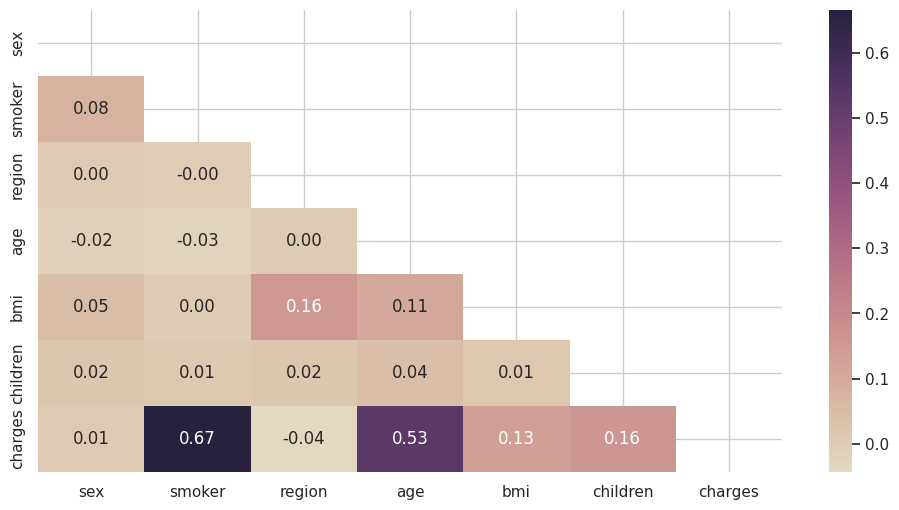

In [21]:
corr = df[FEATURES].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=CORR_FIGURE_SIZE)
sns.heatmap(corr, mask=mask, cmap=sns.color_palette(CORR_PALETTE, as_cmap=True), annot=True, fmt=VALUE_FORMATING)
plt.show()

#### Observations


---


1. **Key Features**: `smoker` have
   significant correlations with `charges`, showing their
   importance for the predictive model (there's also some linear correlation to `age` and `bmi`).

2. **Weak Correlations**: Features like `region` and
   `children` exhibit minimal correlation with `charges`, making them potential candidates for exclusion to simplify the model and possibly enhance performance.

3. The low correlation between sex and other features (like charges, age, bmi) suggests that the gender of the person doesn't have a strong linear influence on these variables when encoded numerically.

---



### Identifying Outliers Across TOP10 Skewed Distributions (Boxplot)

In [22]:
# Calculate Z-scores for each numeric column in the DataFrame
z_scores = np.abs(stats.zscore(df[['age', 'bmi', 'charges']]))

# Set the Z-score threshold (commonly 3, meaning 3 standard deviations from the mean)
threshold = 2.75

# Identify outliers where the Z-score exceeds the threshold for any feature
outliers = df[(z_scores > threshold).any(axis=1)].copy()

# Display the outliers
outliers[LABEL] = outliers[LABEL].apply(np.exp)
print(outliers)

      index  age  sex    bmi  children  smoker  region     charges
116     116   58    1  49.06         0       0       2  11381.3254
286     286   46    0  48.07         2       0       0   9432.9253
401     401   47    1  47.52         1       0       2   8083.9198
847     847   23    1  50.38         1       0       2   2438.0552
860     860   37    0  47.60         2       1       3  46113.5110
1047   1047   22    1  52.58         1       1       2  44501.3982
1088   1088   52    1  47.74         1       0       2   9748.9106
1317   1317   18    1  53.13         0       0       2   1163.4627


#### Observations


---


- **Age, BMI, and children** are the primary features showing outlier values in this dataset.
- **BMI values above 47** are consistently outliers in this dataset.


---



### Comparative Kernel Density Estimation: Categorical features' charges distribution

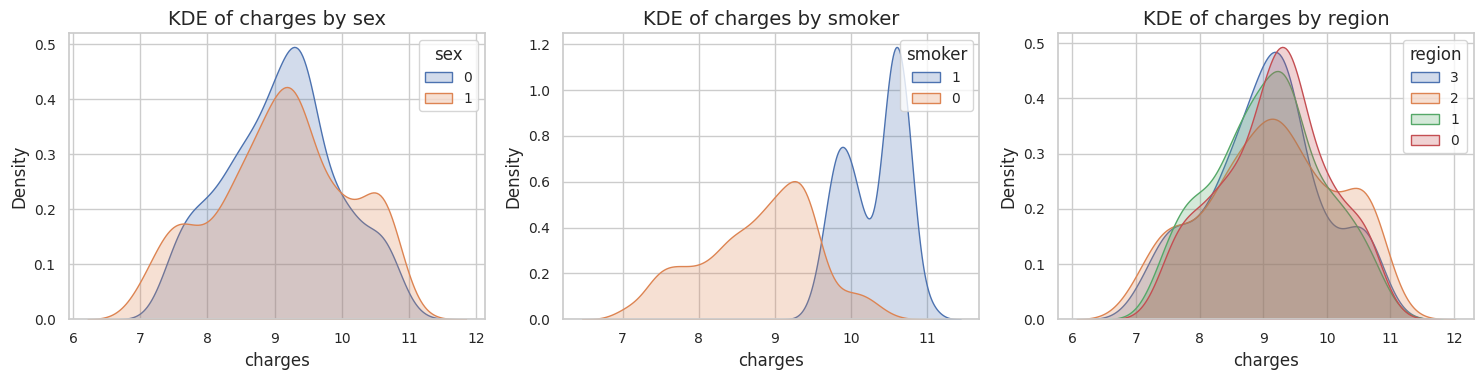

In [23]:
NUM_COLUMNS = len(CATEGORICAL_FEATURES)
NUM_ROWS = len(CATEGORICAL_FEATURES) // NUM_COLUMNS + 1

fig, axes = plt.subplots(NUM_ROWS, NUM_COLUMNS, figsize=(15, 7))

for index, feature in enumerate(CATEGORICAL_FEATURES):
    row, col = divmod(index, NUM_COLUMNS)
    ax = axes[row, col]

    # Plot KDE for each category within the feature (e.g., male/female for sex)
    for category in df[feature].unique():
        sns.kdeplot(df[df[feature] == category][LABEL], ax=ax, label=category, shade=True)

    ax.set_title(f'KDE of {LABEL} by {feature}', fontsize=14)
    ax.legend(title=feature, fontsize=10)
    ax.tick_params(axis='both', labelsize=10)

for i in range(index + 1, NUM_ROWS * NUM_COLUMNS):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

#### Observations


---

**Highly Influential Feature**:
- **Smoker** stands out as the most influential feature due to the clear separation between smokers and non-smokers. This feature has a distinct bimodal distribution for smokers and indicates a strong relationship with higher medical costs.

**Weakly Influential Features**:
- **Sex** and **region** show significant overlap in their KDE distributions, suggesting these features have limited predictive power regarding medical charges.
- These features could add noise to a predictive model, and removing or transforming them might improve the model's performance.

---



## Normality check - (Charges | Categorical values)

In [24]:
# Function to check normality using Kolmogorov-Smirnov test
def check_normality(df, categorical_columns, continuous_column):
    """
    Check normality of the continuous variable within each category of the categorical variables.

    H0: The sample comes from a normal distribution.
    H1: The sample does not come from a normal distribution.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - categorical_columns (list): List of categorical columns to group by.
    - continuous_column (str): The continuous variable to check for normality.

    Returns:
    - results (dict): KS statistics and p-values for each category of each categorical variable.
    """
    results = {}

    for cat_col in categorical_columns:
        categories = df[cat_col].unique()
        cat_results = {}

        for category in categories:
            subset = df[df[cat_col] == category][continuous_column]
            ks_stat, p_value = kstest(subset, 'norm', args=(subset.mean(), subset.std()))
            cat_results[category] = {'KS Statistic': ks_stat, 'p-value': p_value}

        results[cat_col] = cat_results

    return results

# Function to print normality test results with final interpretation
def print_normality_results(normality_results):
    """
    Print the results of the normality tests with final interpretation.

    Parameters:
    - normality_results (dict): The results from the normality tests.
    """
    for cat_col, cat_results in normality_results.items():
        print(f"Results for categorical column: {cat_col}")
        for category, result in cat_results.items():
            ks_stat = result['KS Statistic']
            p_value = result['p-value']
            print(f"  Category {category} - KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")
            if p_value > 0.05:
                print(f"  -> {category} follows a normal distribution (fail to reject H0)")
            else:
                print(f"  -> {category} does not follow a normal distribution (reject H0)")
        print("\n")

# Define categorical and continuous columns
categorical_columns = ['smoker', 'region', 'sex']
continuous_column = 'charges'

# Check normality
normality_results = check_normality(df, categorical_columns, continuous_column)

# Print results with final interpretation
print_normality_results(normality_results)

Results for categorical column: smoker
  Category 1 - KS Statistic: 0.1529, p-value: 0.0000
  -> 1 does not follow a normal distribution (reject H0)
  Category 0 - KS Statistic: 0.0709, p-value: 0.0000
  -> 0 does not follow a normal distribution (reject H0)


Results for categorical column: region
  Category 3 - KS Statistic: 0.0534, p-value: 0.3021
  -> 3 follows a normal distribution (fail to reject H0)
  Category 2 - KS Statistic: 0.0616, p-value: 0.1214
  -> 2 follows a normal distribution (fail to reject H0)
  Category 1 - KS Statistic: 0.0460, p-value: 0.4829
  -> 1 follows a normal distribution (fail to reject H0)
  Category 0 - KS Statistic: 0.0494, p-value: 0.3962
  -> 0 follows a normal distribution (fail to reject H0)


Results for categorical column: sex
  Category 0 - KS Statistic: 0.0347, p-value: 0.3931
  -> 0 follows a normal distribution (fail to reject H0)
  Category 1 - KS Statistic: 0.0491, p-value: 0.0744
  -> 1 follows a normal distribution (fail to reject H0)




# Statistical Tests

In [25]:
# Function to perform Mann-Whitney U Test
def mann_whitney_u_test(df, col, target):
    categories = df[col].unique()
    if len(categories) != 2:
        raise ValueError("Mann-Whitney U Test can only be used with binary categorical variables.")
    group1 = df[df[col] == categories[0]][target]
    group2 = df[df[col] == categories[1]][target]
    stat, p_value = mannwhitneyu(group1, group2)
    print(f"Results for {col}:")
    print(f"  Mann-Whitney U Test Statistic: {stat:.4f}, p-value: {p_value}")
    if p_value < 0.05:
        print(f"  -> Reject the null hypothesis: The distribution of {target} is significantly different between {categories[0]} and {categories[1]}.")
    else:
        print(f"  -> Fail to reject the null hypothesis: The distribution of {target} is not significantly different between {categories[0]} and {categories[1]}.")
    print("\n")

# Function to perform ANOVA Test
def anova_test(df, col, target):
    categories = df[col].unique()
    groups = [df[df[col] == category][target] for category in categories]
    stat, p_value = f_oneway(*groups)
    print(f"Results for {col}:")
    print(f"  ANOVA Test Statistic: {stat:.4f}, p-value: {p_value}")
    if p_value < 0.05:
        print(f"  -> Reject the null hypothesis: At least one group mean of {target} is significantly different among {col} categories.")
    else:
        print(f"  -> Fail to reject the null hypothesis: There are no significant differences in group means of {target} among {col} categories.")
    print("\n")

# Function to perform T-Test
def t_test(df, col, target):
    categories = df[col].unique()
    if len(categories) != 2:
        raise ValueError("T-Test can only be used with binary categorical variables.")
    group1 = df[df[col] == categories[0]][target]
    group2 = df[df[col] == categories[1]][target]
    stat, p_value = ttest_ind(group1, group2)
    print(f"Results for {col}:")
    print(f"  T-Test Statistic: {stat:.4f}, p-value: {p_value}")
    if p_value < 0.05:
        print(f"  -> Reject the null hypothesis: The means of {target} are significantly different between {categories[0]} and {categories[1]}.")
    else:
        print(f"  -> Fail to reject the null hypothesis: The means of {target} are not significantly different between {categories[0]} and {categories[1]}.")
    print("\n")

## Q1: Relationship Between BMI and Medical Charges

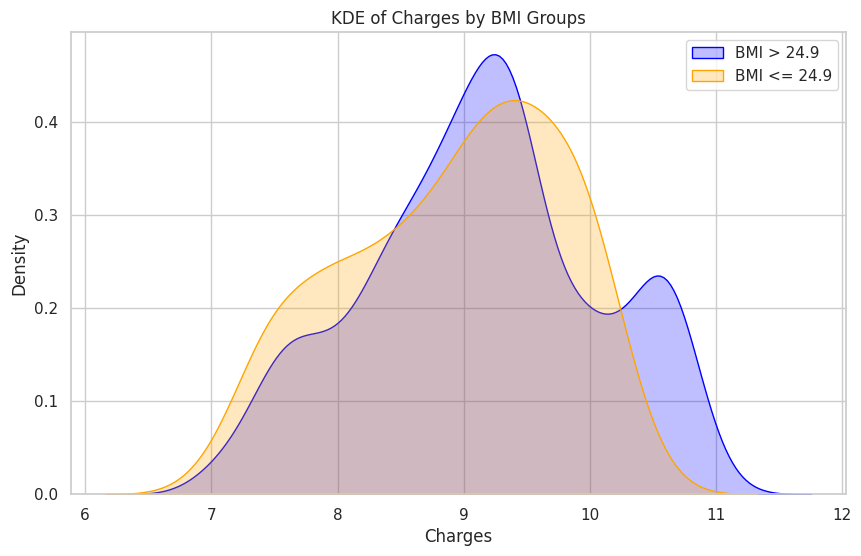

Normality test results for BMI > 24.9: KS Statistic = 0.0520, p-value = 0.0052
Normality test results for BMI <= 24.9: KS Statistic = 0.0770, p-value = 0.1076

Mann-Whitney U Test: Statistic = 147675.0000, p-value = 0.0056
Null Hypothesis: The distributions of charges are equal between the two BMI groups.
Conclusion: Reject the null hypothesis. There is a significant difference in charges between the two BMI groups.


In [26]:
# Split the data into two groups based on BMI
bmi_threshold = 24.9
group1 = df[df['bmi'] > bmi_threshold]['charges']
group2 = df[df['bmi'] <= bmi_threshold]['charges']

# Plot KDE for both groups
plt.figure(figsize=(10, 6))
sns.kdeplot(group1, shade=True, label=f'BMI > {bmi_threshold}', color='blue')
sns.kdeplot(group2, shade=True, label=f'BMI <= {bmi_threshold}', color='orange')
plt.title('KDE of Charges by BMI Groups')
plt.xlabel('Charges')
plt.ylabel('Density')
plt.legend()
plt.show()

# Check normality of the distributions
stat1, p_value1 = kstest(group1, 'norm', args=(group1.mean(), group1.std()))
stat2, p_value2 = kstest(group2, 'norm', args=(group2.mean(), group2.std()))

print(f'Normality test results for BMI > {bmi_threshold}: KS Statistic = {stat1:.4f}, p-value = {p_value1:.4f}')
print(f'Normality test results for BMI <= {bmi_threshold}: KS Statistic = {stat2:.4f}, p-value = {p_value2:.4f}')

# Determine which test to use based on normality
if p_value1 > 0.05 and p_value2 > 0.05:
    # Both groups follow a normal distribution
    stat, p_value = ttest_ind(group1, group2)
    test_name = 'Independent T-Test'
    test_hypothesis = "The means of charges are equal between the two BMI groups."
else:
    # At least one group does not follow a normal distribution
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    test_name = 'Mann-Whitney U Test'
    test_hypothesis = "The distributions of charges are equal between the two BMI groups."

# Output the results
print(f'\n{test_name}: Statistic = {stat:.4f}, p-value = {p_value:.4f}')
print(f"Null Hypothesis: {test_hypothesis}")

# Conclusion based on the test
if p_value < 0.05:
    print(f"Conclusion: Reject the null hypothesis. There is a significant difference in charges between the two BMI groups.")
else:
    print(f"Conclusion: Fail to reject the null hypothesis. There is no significant difference in charges between the two BMI groups.")


## Q2: Relationship Between Age and Medical Charges

In [27]:
corr[LABEL][corr[LABEL] > 0.15]['age']

0.5278340489394341

**Conclusion**: there is a positive linear relationship between age and charges.

## Q3: Relationship Between Region and Medical Charges

In [28]:
anova_test(df, 'region', 'charges')

Results for region:
  ANOVA Test Statistic: 1.4020, p-value: 0.24056202996153775
  -> Fail to reject the null hypothesis: There are no significant differences in group means of charges among region categories.




**Conclusion**: there is a no relationship between region and charges.

## Q4: Impact of Smoking on Medical Charges

In [29]:
mann_whitney_u_test(df, 'smoker', 'charges')

Results for smoker:
  Mann-Whitney U Test Statistic: 284133.0000, p-value: 5.270233444503571e-130
  -> Reject the null hypothesis: The distribution of charges is significantly different between 1 and 0.




**Conclusion**: there is a strong, positive linear relationship between region and charges. (according to both correlation heatmap and our statistical test)

## Extra Question: Relationship Between Sex and Medical Charges

In [30]:
t_test(df, 'sex', 'charges')

Results for sex:
  T-Test Statistic: -0.2059, p-value: 0.8369352885900301
  -> Fail to reject the null hypothesis: The means of charges are not significantly different between 0 and 1.




**Conclusion**: there is no relationship between sex and charges - as we would expect.

# Baseline Model Training - Linear Regression

shifting from EDA to Linear Regression training with 10-fold cross-validation.

### Data Preparation

In [31]:
def data_preparation(training_df, labels, test_size=TEST_PORTION, random_state=SEED):
    X = training_df.values
    Y = labels.values

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    return X_train, X_test, Y_train, Y_test

Encode categorical features to to one-hot representation for training

NOTE: We previously applied a log transformation to the `charges` column to reduce skewness and make the distribution more Gaussian-like, which helps with model convergence. During inference, we'll simply apply the inverse (exponential) function $e^x$ to revert the transformation, as the natural logarithm is bijective.


In [32]:
onehot_df = df.copy()

encoder = OneHotEncoder(sparse_output=False)

for column in ['region']:
    encoded = encoder.fit_transform(df[[column]])
    encoded_col_names = [f"{column}_{cat}" for cat in encoder.categories_[0]]
    onehot_df = onehot_df.drop(columns=[column]).join(pd.DataFrame(encoded, columns=encoded_col_names, index=df.index))

In [33]:
onehot_df

,index,age,sex,bmi,children,smoker,charges,region_0,region_1,region_2,region_3
0,0,19,0,27.900,0,1,9.734176,0.0,0.0,0.0,1.0
1,1,18,1,33.770,1,0,7.453302,0.0,0.0,1.0,0.0
2,2,28,1,33.000,3,0,8.400538,0.0,0.0,1.0,0.0
3,3,33,1,22.705,0,0,9.998092,0.0,1.0,0.0,0.0
4,4,32,1,28.880,0,0,8.260197,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1333,1333,50,1,30.970,3,0,9.268661,0.0,1.0,0.0,0.0
1334,1334,18,0,31.920,0,0,7.698927,1.0,0.0,0.0,0.0
1335,1335,18,0,36.850,0,0,7.396233,0.0,0.0,1.0,0.0
1336,1336,21,0,25.800,0,0,7.604867,0.0,0.0,0.0,1.0


Create training and test sets

In [34]:
training_df = onehot_df.drop([LABEL], axis=1)
labels_df = onehot_df[LABEL]
X_train_with_id, X_test_with_id, Y_train, Y_test = data_preparation(training_df, labels_df)
X_train, X_test = X_train_with_id[:, 1:], X_test_with_id[:, 1:]

## Training

### Training Loop
This loop facilitates the training and evaluation of models through K-Fold cross-validation:

1. **Splitting the data**: Data is divided into training and validation sets using K-Fold.
2. **Training the model**: A new model is trained for each fold using the training data.
3. **Storing models**: Each trained model is saved into a collection for analysis.
4. **Evaluating performance**: Metrics are calculated for both training and validation sets.
5. **Selecting the best model**: The model with the best validation score is selected.


In [35]:
def training_loop(X_train, Y_train, kf, metrics_dict, return_only_model=True):
    # Initialize lists to store training and test metrics
    train_metrics = {metric: [] for metric in metrics_dict.keys()}
    test_metrics = {metric: [] for metric in metrics_dict.keys()}
    models = []

    best_model = None
    best_metric_score = float('inf')
    best_model_idx = -1

    # Perform KFold cross-validation
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        x_train, x_val = X_train[train_idx], X_train[val_idx]
        y_train, y_val = Y_train[train_idx], Y_train[val_idx]

        # Initialize and train the model for this fold
        model = LinearRegression()
        model.fit(x_train, y_train)
        models.append(model)  # Save the model for this fold

        # Predict on training and validation sets
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)

        # Calculate metrics for both training and validation sets
        for metric_name, metric_func in metrics_dict.items():
            train_metrics[metric_name].append(metric_func(y_train, y_train_pred))
            test_metrics[metric_name].append(metric_func(y_val, y_val_pred))

        # Check if this fold's model has the best validation score based on the given metric criteria
        if test_metrics[METRIC_CRITERIA][-1] < best_metric_score:
            best_metric_score = test_metrics[METRIC_CRITERIA][-1]
            best_model = model
            best_model_idx = fold_idx

    if return_only_model:
      return best_model

    return best_model, best_model_idx, train_metrics, test_metrics

In [36]:
kf = KFold(n_splits=NUM_KFOLD, shuffle=True, random_state=SEED)
best_model, best_model_idx, train_metrics, test_metrics = training_loop(X_train, Y_train, kf, metrics_dict, return_only_model=False)

print(f"Best model fold: {best_model_idx + 1}")
print(f"Best {METRIC_CRITERIA} score: {np.min(test_metrics[METRIC_CRITERIA])}")

Best model fold: 6
Best mean_squared_error score: 0.1573706307834239


## Evaluation Metrics and Results

### Plotting Training & Validation Metrics for Best-Fold

Ploting a series of graphs for training and validation metrics over different folds.

#### Parameters:
- evals_results: Contains 'train' and 'val' keys with metric names and epoch values.
- metrics: List of metric names to plot (e.g., 'MSE', 'RMSE').


In [37]:
def plot_metrics_row(train_metrics, test_metrics, metrics_names, figsize=(20, 3), lw=2):
    fig, axes = plt.subplots(1, len(metrics_names), figsize=figsize)

    for ax, metric_name in zip(axes, metrics_names):
        folds = range(1, len(train_metrics[metric_name]) + 1)  # Number of folds
        ax.plot(folds, train_metrics[metric_name], label=f'{metric_name}_train', color='blue', lw=lw)
        ax.plot(folds, test_metrics[metric_name], label=f'{metric_name}_val', color='orange', lw=lw)
        ax.set_title(f'{metric_name} Across Folds')
        ax.set_ylabel(metric_name)
        ax.set_xlabel('Fold')
        ax.legend()

    plt.tight_layout()
    plt.show()

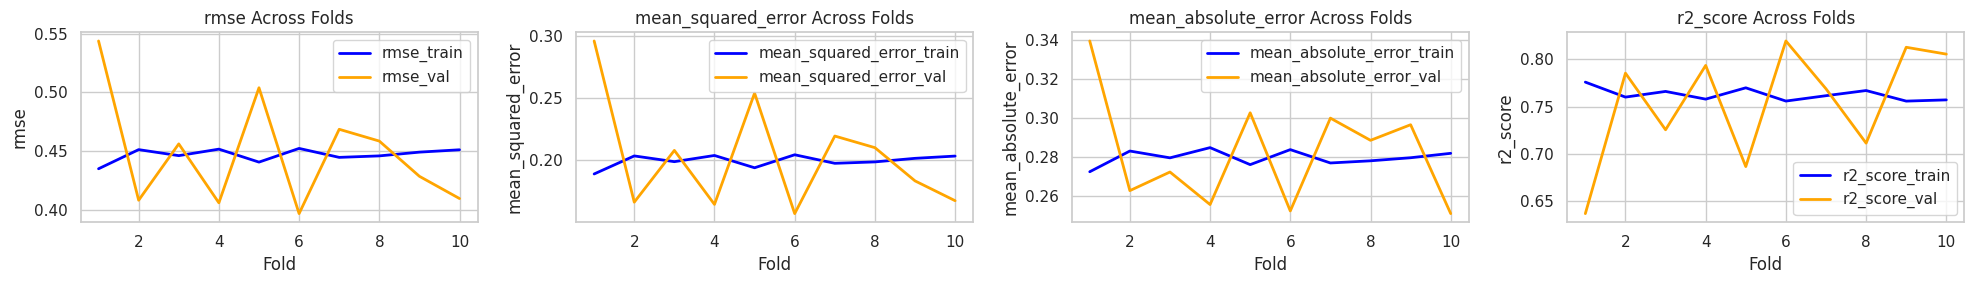

In [38]:
plot_metrics_row(train_metrics, test_metrics, metrics_dict.keys())

#### Observations

---

- **Cross-Fold Variability:** While training is stable, validation metrics show variability in how the model performs on different data splits.
- **Generalization:** There is room for improvement in generalization, as validation performance is less consistent, possibly requiring further tuning or regularization.

---

### Summary of best fold performance

Summarizing the results over the test split

In [39]:
def visualize_test_results(metrics_dict, X_test, Y_test, best_model):
  rows = []
  for metric, func in metrics_dict.items():
      # For other metrics, calculate directly
      value = func(Y_test, best_model.predict(X_test))
      rounded_value = round(value, METRIC_FP_PRECISION)
      rows.append([metric, rounded_value])

  df_metrics = pd.DataFrame(rows, columns=['Metric', 'Best_Fold_on_Test'])
  return df_metrics

In [40]:
baseline_metrics = visualize_test_results(metrics_dict, X_test, Y_test, best_model)
baseline_metrics

,Metric,Best_Fold_on_Test
0,rmse,0.404
1,mean_squared_error,0.163
2,mean_absolute_error,0.258
3,r2_score,0.808


# Feature Engineering

In [41]:
def compare_models(dfs, names, postfix='_Best_Fold'):
    modified_dfs = []

    for df, name in zip(dfs, names):
        renamed_df = df.rename(columns={"Best_Fold_on_Test": f"{name}{postfix}"})
        modified_dfs.append(renamed_df)

    comparison_df = modified_dfs[0]
    for mod_df in modified_dfs[1:]:
        comparison_df = pd.merge(comparison_df, mod_df, on='Metric')

    return comparison_df

### Standardization (Z-score)

**Note:** we should avoid applying z-score normalization to categorical features that have undergone one-hot encoding, as this would disrupt the 'binary indicator' relationship where each category is uniquely identified by zeros and ones. This mutual exclusivity is essential for models to correctly interpret the presence or absence of categorical attributes.

In [42]:
scaler = StandardScaler()

# Make a copy of the training and test data to apply scaling
X_train_scaled = np.copy(X_train_with_id)
X_test_scaled = np.copy(X_test_with_id)

# Extract numerical features without the label and then extract their indices in the dataframe
numerical_features = [feature for feature in training_df.columns if feature in NUMERICAL_FEATURES]
numerical_indices = [i for i, col in enumerate(training_df.columns) if col in numerical_features]

# Fit the scaler only on the numerical columns of the training data
scaler.fit(X_train[:, numerical_indices])

# Apply the transformation to both train and test sets and only to the numerical columns
X_train_scaled[:, numerical_indices] = scaler.transform(X_train_scaled[:, numerical_indices])
X_test_scaled[:, numerical_indices] = scaler.transform(X_test_scaled[:, numerical_indices])

X_train_scaled = X_train_scaled[:, 1:]
X_test_scaled = X_test_scaled[:, 1:]

# Train the model with the scaled training data
best_model_scaled = training_loop(X_train_scaled, Y_train, kf, metrics_dict)
standardized_metrics = visualize_test_results(metrics_dict, X_test_scaled, Y_test, best_model_scaled)

# Compare baseline and standardized models
standardization_comparison_df = compare_models([baseline_metrics, standardized_metrics], ['Baseline', 'Standardized'])
display(standardization_comparison_df)

,Metric,Baseline_Best_Fold,Standardized_Best_Fold
0,rmse,0.404,0.404
1,mean_squared_error,0.163,0.163
2,mean_absolute_error,0.258,0.258
3,r2_score,0.808,0.808


feature standartization in order to prevent dominance of certain features during model training.  

## Feature Selection

In [43]:
CHARGES_CORR_THRESHOLD = 0.15
corr_with_diagnosis = corr[LABEL]

# Identify features with low correlation with the target variable
low_corr_features = corr_with_diagnosis[abs(corr_with_diagnosis) < CHARGES_CORR_THRESHOLD].index.tolist()
print("Dropped features with absolute correlation value less than", CHARGES_CORR_THRESHOLD, ":", low_corr_features)

Dropped features with absolute correlation value less than 0.15 : ['sex', 'region', 'bmi']


In [44]:
# Extract feature names in the one-hot encoding representation
low_corr_oh_features = [f for f in training_df.columns for f_to_rem in low_corr_features if f.startswith(f_to_rem)]

# Get column indices to drop
drop_indices = [training_df.columns.get_loc(feature) for feature in low_corr_oh_features]

# Remove low-correlation features from the training and test sets
FS_X_train = np.delete(X_train_with_id, drop_indices, axis=1)[:, 1:]
FS_X_test = np.delete(X_test_with_id, drop_indices, axis=1)[:, 1:]

# Train the model using the filtered features
best_model_fs = training_loop(FS_X_train, Y_train, kf, metrics_dict)

# Evaluate the model on the test set with selected features
fs_metrics = visualize_test_results(metrics_dict, FS_X_test, Y_test, best_model_fs)

In [45]:
fs_comparison_df = compare_models([baseline_metrics, fs_metrics], ['Baseline', 'Feature_Selection'])
display(fs_comparison_df)

,Metric,Baseline_Best_Fold,Feature_Selection_Best_Fold
0,rmse,0.404,0.417
1,mean_squared_error,0.163,0.174
2,mean_absolute_error,0.258,0.244
3,r2_score,0.808,0.795


Feature selection based on exploratory data analysis (EDA).

## Feature Extraction (Dimentionality Reduction) - PCA

In [46]:
# PCA transformation
pca = PCA(n_components=3)
PCA_X_train = pca.fit_transform(X_train)
PCA_X_test = pca.transform(X_test)

# Training with PCA-transformed data
best_model_pca = training_loop(PCA_X_train, Y_train, kf, metrics_dict)

# Evaluate the model on PCA-transformed test data
pca_metrics = visualize_test_results(metrics_dict, PCA_X_test, Y_test, best_model_pca)

In [47]:
# Compare baseline metrics with PCA-transformed data metrics
pca_comparison_df = compare_models([baseline_metrics, pca_metrics], ['Baseline', 'PCA'])
display(pca_comparison_df)

,Metric,Baseline_Best_Fold,PCA_Best_Fold
0,rmse,0.404,0.795
1,mean_squared_error,0.163,0.632
2,mean_absolute_error,0.258,0.640
3,r2_score,0.808,0.254


As previously discussed, our dataset has multiple uncorrelated features, using PCA, which creates fewer, orthogonal features from linear combinations of the original ones. This approach offers:

- Noise Reduction
- Lower Data Complexity
- Independent Features

## Hard-Outliers Removal

In [48]:
indices_to_remove = outliers.index.values

# Apply the removal of outliers on the training and test sets
train_mask = ~np.isin(X_train_with_id[:, 0], indices_to_remove)  # Mask for the training set (remove outliers)
test_mask = ~np.isin(X_test_with_id[:, 0], indices_to_remove)    # Mask for the test set (remove outliers)

# Filter the training and test sets to remove the identified outliers
OR_X_train = X_train_with_id[train_mask][:, 1:]  # Remove 'id' column after filtering
OR_Y_train = Y_train[train_mask]

OR_X_test = X_test_with_id[test_mask][:, 1:]     # Remove 'id' column after filtering
OR_Y_test = Y_test[test_mask]

print(f"{len(indices_to_remove)} outliers have been removed from the dataset.")

# Train the model on the data without outliers
best_model_or = training_loop(OR_X_train, OR_Y_train, kf, metrics_dict)

# Evaluate the model on the test set without outliers
outliers_metrics = visualize_test_results(metrics_dict, OR_X_test, OR_Y_test, best_model_or)

8 outliers have been removed from the dataset.


In [49]:
outliers_comparison_df = compare_models([baseline_metrics, outliers_metrics], ['Baseline', 'Outliers_Removal'])
display(outliers_comparison_df)

,Metric,Baseline_Best_Fold,Outliers_Removal_Best_Fold
0,rmse,0.404,0.404
1,mean_squared_error,0.163,0.163
2,mean_absolute_error,0.258,0.259
3,r2_score,0.808,0.808


The outliers in our dataset represent extreme data points across multiple features. (std > 3)

Though not ideal, we can remove these data points and label them as abnormal, as they might not be representative of typical data.

To decide which points to remove, we set a threshold based on the number of outlier features in each data point.

## Summary

For our baseline model, with default configuration:

| Method                         | Improvement                |
|-------------------------------|----------------------------|
| Principal Component Analysis (PCA) | Bad Effect                 |
| Feature Selection              | Bad Effect                |
| Outlier Removal                 | No Effect                |
| Scaling                          | No Effect                   |


To improve our best model from HyperParameter fine-tuning, we will combine the top feature engineering methods and test each individually to assess their unique impact on model performance.

# Alternative ML Models Training

We will explore 3 alternatives for our baseline model, combining hyperparameter tuning.

- XGBoost
- Random Forest
- Support Vector Machine


## XGBoost

   
* **Motivation**: To evaluate if a baseline model's performance can be improved through parameter configuration search compared to default settings.  

* **Configuration** idea: Employ a RandomizedSearchCV with varied distributions for key hyperparameters, including learning rate, estimators, depth, child weight, gamma, and subsample rate, using cross-validation to identify the best-performing XGBoost configuration.



### Parameters Configuration

In [50]:
xgboost_conf = {
    'model': XGBRegressor(random_state=SEED),
    'param_dict': {
        'learning_rate': uniform(0.001, 0.3),
        'n_estimators': randint(100, 1000),
        'max_depth': randint(1, 10),
        'min_child_weight': norm(3, 1),
        'gamma': uniform(0, 0.3),
        'subsample': uniform(0.7, 0.3),
    },
    'random_result': None
}

## Random Forest

* **Motivation**: Random Forest is robust, leveraging an ensemble of decision trees to provide stability and resilience against overfitting.

* **Configuration idea**: Utilize RandomizedSearchCV with varied distributions for key hyperparameters in Random Forest, such as the number of estimators, maximum features, depth, samples required for split and leaf, and whether to bootstrap. Use cross-validation to find the optimal configuration for improved accuracy and robustness.  


### Parameters Configuration

In [51]:
rf_conf = {
    'model': RandomForestRegressor(random_state=SEED),
    'param_dict': {
        'n_estimators': randint(100, 500),
        'max_features': ['log2'],
        'max_depth': randint(1, 6),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'bootstrap': [True, False]
    },
    'random_result': None
}

## SVM

* **Motivation**: SVM is known for its robustness and effectiveness in high-dimensional spaces like ours [30+ features]

* **Configuration idea**: Apply RandomizedSearchCV with varied distributions to optimize SVM's hyperparameters, including C, kernel, \
degree, gamma, coef0, shrinking, and tolerance. Utilize cross-validation to identify the optimal SVM configuration for better \
accuracy and generalization.  


### Parameters Configuration

In [52]:
svm_conf = {
    'model': SVR(),
    'param_dict': {
        'C': uniform(0.01, 10),
        'kernel': ['linear', 'rbf'],
        'degree': randint(1, 10),
        'gamma': ['scale', 'auto'],
        'coef0': uniform(0, 10),
        'shrinking': [True, False],
        'tol': uniform(1e-5, 1e-1),
    },
    'random_result': None
}

## Perform Grid Search For on all of the models (SVM, XGBoost, Random Forest)

Combine Configurations

In [53]:
gs_conf = {
    'SVM': svm_conf,
    'XGBoost': xgboost_conf,
    'RF': rf_conf
}

Run Hyper-Parameter fine-tuning for all the models

In [54]:
# Run hyperparameters finetuning for our chosen models
metrics_results = [baseline_metrics]
best_configurations = {name: None for name in gs_conf.keys()}
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

for m_name, m_conf in tqdm(gs_conf.items(), total=len(gs_conf), desc='Training models'):
    random_search = RandomizedSearchCV(estimator=m_conf['model'], param_distributions=m_conf['param_dict'], scoring=SCIKIT_METRIC_CRITERIA, cv=cv, n_iter=5, random_state=SEED, n_jobs=-1)

    m_conf['random_result'] = random_search.fit(X_train, Y_train)
    best_configurations[m_name] = m_conf['random_result'].best_params_

    # pred on test set using the model with the best parameters
    best_model = random_search.best_estimator_
    metrics_results.append(visualize_test_results(metrics_dict, X_test, Y_test, best_model))

# compare to baseline model
models_comparison_df = compare_models(metrics_results, ['Baseline'] + [f'GridSearch_{m_name}' for m_name in gs_conf])
print(f'\nbest models configurations were: {best_configurations}')
display(models_comparison_df)

Training models: 100%|██████████| 3/3 [01:36<00:00, 32.12s/it]


best models configurations were: {'SVM': {'C': 6.468941130666561, 'coef0': 4.375872112626925, 'degree': 7, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': 0.03835415188257778}, 'XGBoost': {'gamma': 0.24027322559389325, 'learning_rate': 0.15714324386536144, 'max_depth': 4, 'min_child_weight': 3.313067701650901, 'n_estimators': 365, 'subsample': 0.8612119688347032}, 'RF': {'bootstrap': False, 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 342}}


,Metric,Baseline_Best_Fold,GridSearch_SVM_Best_Fold,GridSearch_XGBoost_Best_Fold,GridSearch_RF_Best_Fold
0,rmse,0.404,0.427,0.311,0.580
1,mean_squared_error,0.163,0.182,0.097,0.337
2,mean_absolute_error,0.258,0.241,0.173,0.465
3,r2_score,0.808,0.785,0.886,0.603


Based on the following results, the XGBoost model with specified cross-validation performs the best compared to our baseline, SVM, and Random Forest models. With this optimal configuration identified, we'll use it along with effective feature engineering to enhance the model's performance.

# Optimal Model and Feature Engineering Combinations

In [55]:
datasets = {
    'Baseline Data': (X_train, Y_train, X_test, Y_test),
    'PCA': (PCA_X_train, Y_train, PCA_X_test, Y_test),
    'Hard-Outliers Removal': (OR_X_train, OR_Y_train, OR_X_test, OR_Y_test),
    'Feature Selection': (FS_X_train, Y_train, FS_X_test, Y_test),
}

xgboost_conf = {
    'model': XGBRegressor(random_state=SEED),
    'param_dict': best_configurations['XGBoost']
}

metrics_results = []
model_dict = {}
for dataset_name, (_X_train, _Y_train, _X_test, _Y_test) in tqdm(datasets.items(), total=len(datasets), desc='Training chosen model over datasets'):

    # Initialize model with the given configuration
    xgboost_model = XGBRegressor(
        random_state=xgboost_conf['model'].random_state,
        **xgboost_conf['param_dict']
    )

    # Train the model over all dataset
    xgboost_model.fit(_X_train, _Y_train)

    model_dict[dataset_name] = xgboost_model

    # Visualize test results
    metrics_results.append(visualize_test_results(metrics_dict, _X_test, _Y_test, xgboost_model))

combination_comparison_df = compare_models(metrics_results, datasets.keys(), postfix='')
display(combination_comparison_df)

Training chosen model over datasets: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


,Metric,Baseline Data,PCA,Hard-Outliers Removal,Feature Selection
0,rmse,0.311,0.842,0.291,0.359
1,mean_squared_error,0.097,0.709,0.085,0.129
2,mean_absolute_error,0.173,0.606,0.160,0.232
3,r2_score,0.886,0.163,0.900,0.848


In [56]:
best_dataset = 'Hard-Outliers Removal'
_X_train, _Y_train, _X_test, _Y_test = datasets[best_dataset]
model = model_dict[best_dataset]
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.24027322559389325, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15714324386536144,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3.313067701650901, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=365,
             n_jobs=None, num_parallel_tree=None, random_state=0, ...)

#### Observations


---


Based on our comprehensive evaluation of different models

1. **Baseline (Linear Regression)**
2. **XGBoost + Cross-Validation (CV)**
3. **SVM + Cross-Validation (CV)**
4. **RandomForest + Cross-Validation (CV)**

The best combination to maximize $R^2$ score and minimizes RMSE is **"XGBoost + CV"** trained on the baseline dataset, after Outliers-removal. It's worth to mention that, XGBoost can automatically select features.


---

# Model Explainability Analysis

Utilizing SHAP (stands for: SHapley Additive exPlanations) is a method in machine learning that helps us understand how our model works. It breaks down each prediction into parts and tells us which features are most important for that prediction.

## SHAP Summary Plots

In [57]:
training_df.columns[1:]

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_0', 'region_1',
       'region_2', 'region_3'],
      dtype='object')

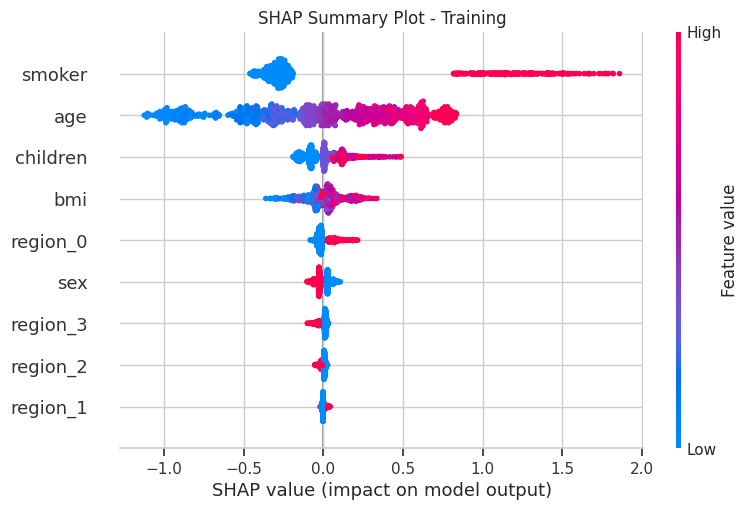

In [58]:
explainer = shap.Explainer(model)

# Restore numpy to df
_X_train_df = pd.DataFrame(_X_train, columns=training_df.columns[1:])
_X_test_df = pd.DataFrame(_X_test, columns=training_df.columns[1:])

shap_values_train = explainer.shap_values(_X_train_df)

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values_train, _X_train_df, plot_type='dot', show=False)
plt.title("SHAP Summary Plot - Training")
plt.show()

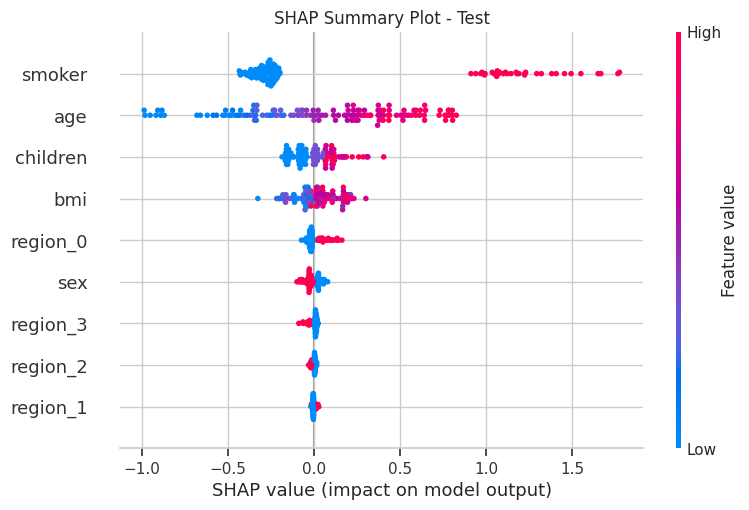

In [59]:
shap_values_test = explainer.shap_values(_X_test_df)

plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values_test, _X_test_df, plot_type='dot', show=False)
plt.title("SHAP Summary Plot - Test")
plt.show()

This SHAP summary plots indicates the impact of various features on the model's predictions. It uses a dot plot to show SHAP values for individual samples, with colors representing the feature's value (blue for low, red for high), and the dots' position indicating the impact on the model's output (left for Benign, right for Malignant).

#### Observations
---

1. **`smoker`**: The most impactful feature, with smokers (red) strongly increasing predictions and non-smokers (blue) decreasing them, consistently across both datasets.

2. **`age`**: Older individuals (red) increase predictions, while younger ones (blue) reduce them. The impact is consistent in both sets.

3. **`children`** and **`bmi`**: Both show moderate effects. More children and higher BMI values slightly increase predictions.

4. **`region`** and **`sex`**: These features have minimal impact, with SHAP values clustering around zero.


---


## Feature Importance

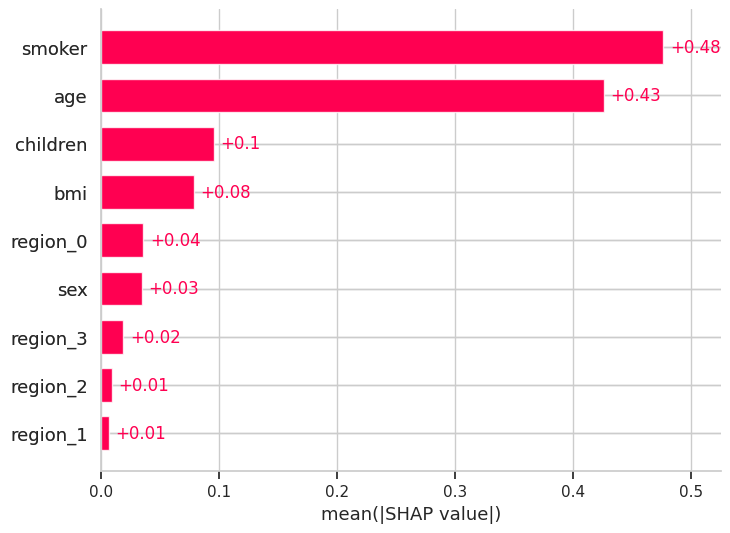

In [60]:
shap.plots.bar(explainer(_X_train_df))

As we already mentioned in Summary Plot's observations, it seems that the most significant features in decision made were indeed the most correlated features.

In [61]:
corr[LABEL][corr[LABEL] > 0.15]

,charges
smoker,0.665506
age,0.527834
children,0.161336
charges,1.000000


# Summary

We chose to work with the [Medical Insurance Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance), which aims to predict insurance cost using 7 numerical & categorical features and a given ground truth (gt).

As we analyzed the data, we noticed that some of these features were crucially highly correlated with the target variable.

We divided the dataset into two splits:
* Training
* Test

The test split was kept unobserved by the model to mimic real-world scenarios.

We used several visualization and analysis methods in our pipeline, such as:

* Features Distribution (Pie & Histograms Charts) – Revealed an exponential distribution, which we smoothed using standartization.
* Pearson Correlation – Identified less correlated features.
* KDE Plots – Revealed distinct patterns in feature distributions.
* Outlier Distribution Analysis – Identified hard-outlier data points.

Based on these analyses, we employed the following feature engineering techniques:

* Feature Selection
* Hard-Outliers Removal
* Principal Component Analysis

We also trained an Linear Regression model with default configuration, achieving fairly good results, with high variance on the test split.

We trained three selected models, now with hyperparameter fine-tuning:
* Support Vector Machine
* Random Forest
* XGBoost

After training and applying feature engineering, we found that the baseline dataset combined with XGBoost and outliers removal provided the best results and achived great results on the testset.

Continuing our analysis, we explored:
1. SHAP summary plots for both test and training data to identify and compare key differences.
2. Feature importance across the training split.

It was intriguing to explore and apply the concepts learned in class.


## Important Notes
- We did not rely on any existing Kaggle notebooks for our analysis.
- Most Kaggle notebooks do not conduct thorough error analysis or extensive Exploratory Data Analysis (EDA) as we did.
